In [12]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.metric.metric import MetricCalculator
from mesostat.utils.hdf5_io import DataStorage
from mesostat.stat.anova import as_pandas, as_pandas_lst, anova_homebrew

from lib.sych.data_fc_db_raw import DataFCDatabase
from lib.sych.plot_helper import imshow_dataset_by_mouse, imshow_dataset_by_session
from lib.sych.metric_helper import metric_by_session

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data'] = './'
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed'
# params['root_path_data'] = gui_fpath('h5path', './')

In [3]:
dataDB = DataFCDatabase(params)

Searching for data files
Extracting trial type names
Extracting data types


In [4]:
ds = DataStorage('sych_result_individual_region.h5')

In [5]:
mc = MetricCalculator(serial=True, verbose=False)

In [6]:
print(dataDB.mice)
print(dataDB.dataTypes)
print(dataDB.trialTypeNames)

{'mvg_4', 'mvg_9', 'mvg_7', 'mvg_8'}
{'raw', 'bn_trial', 'bn_session'}
{'iGO', 'iMISS', 'iFA', 'iNOGO'}


# 1. Noise
## 1.1 SNR via AutoCorrelation

**Plan:**
* AutoCorr[1] is a number that is close to 1 if data is changing slowly, and close to zero if data changes very fast.

**FIXME**:
* Remove Performance above 1
* If performance becomes important, discuss with Y whether to use original or pooled performance, as they differ significantly

In [ ]:
metricName = 'autocorr_d1'
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    for datatype in dataDB.get_data_types():
        dataName = metricName + '_' + datatype
        print(dataName)
        metric_by_session(dataDB, mc, ds, mousename, metricName, 'p', datatype=datatype, dataName=dataName)

In [ ]:
metricName = 'autocorr_d1'
for datatype in dataDB.get_data_types():
    dataName = metricName + '_' + datatype
    imshow_dataset_by_mouse(dataDB, ds, dataName, limits=[0,1])

# 2. Variance

* Across sessions
    - Explained by performance
* Across channels, trials, timesteps
    - Explained by trial type

Things to understand:
* How to compare different rows?
* What models make sense?
* Try linear mixed models?

In [41]:
intervDict = {
    'TEX' : (3.0, 3.5),
    'REW' : (6.0, 6.5)
}

#trialTypeNames = dataDB.get_trial_type_names()
trialTypeNames = ['iGO', 'iNOGO']

dfDict = {}
for mousename in dataDB.mice:
    sessions = dataDB.get_sessions(mousename)
    dfThis = pd.DataFrame()
    for session in sessions:
        for trialType in trialTypeNames:
            dataTrialLst = []
            for intervName, interv in intervDict.items():
                data = dataDB.get_neuro_data({'session' : session}, datatype='bn_session', trialType=trialType, cropTime=interv)[0]
                data = np.mean(data, axis=1)  # Average over timesteps
                dataDF = as_pandas(data, ('trials', 'channels'))
                dataDF['trialType'] = trialType
                dataDF['interval'] = intervName
                dataDF['session'] = session
                dfThis = dfThis.append(dataDF, ignore_index=True)
            
    dfThis = dfThis.drop('trials', axis=1)
    dfDict[mousename] = dfThis

In [52]:
model = '''
    rez ~ C(channels)
    + C(trialType)
    + C(interval)
    + C(session)
    + C(trialType)*C(session)
    + C(trialType)*C(channels)
    + C(interval)*C(channels)
'''

# Session-wide
for mousename in sorted(dataDB.mice):
    print(mousename)
    linModel = ols(model, data=dfDict[mousename]).fit()
    display(sm.stats.anova_lm(linModel, typ=1))

mvg_4


,df,sum_sq,mean_sq,F,PR(>F)
C(channels),47.0,13.465354,0.286497,127.185804,0.000000e+00
C(trialType),1.0,4.412516,4.412516,1958.867351,0.000000e+00
C(interval),1.0,1.521583,1.521583,675.482926,8.489943e-149
C(session),10.0,6.246298,0.624630,277.294631,0.000000e+00
C(trialType):C(session),10.0,1.550256,0.155026,68.821190,2.826944e-141
C(trialType):C(channels),47.0,11.831775,0.251740,111.755980,0.000000e+00
C(interval):C(channels),47.0,8.810111,0.187449,83.215122,0.000000e+00
Residual,407932.0,918.901676,0.002253,NaN,NaN


mvg_7


KeyboardInterrupt: 

mvg_4
mvg_7
mvg_8
mvg_9


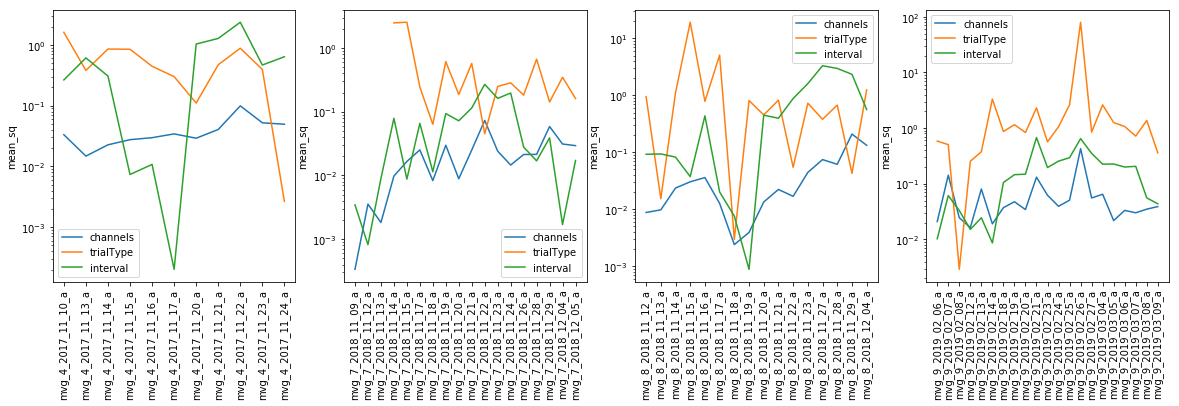

In [47]:
# Across-sessions
nMice = len(dataDB.mice)
fig, ax = plt.subplots(ncols = nMice, figsize=(5*nMice, 5))

model = '''
rez ~ C(channels)+C(trialType)+C(interval)
'''

for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    dfThis = dfDict[mousename]
    print(mousename)
    sessions = dataDB.get_sessions(mousename)
    plotData = []
    for session in sessions:
        dfSession = dfThis[dfThis['session'] == session]
        linModel = ols(model, data=dfSession).fit()
        rezStat = sm.stats.anova_lm(linModel, typ=1)
        rezStat = rezStat.drop('Residual')
        plotData += [np.array(rezStat['mean_sq'])]

    names = ['channels', 'trialType', 'interval']
    plotData = np.array(plotData).T


    ax[iMouse].set_ylabel('mean_sq')
    for name, x in zip(names, plotData):
        ax[iMouse].semilogy(x, label=name)

    ax[iMouse].set_xticks(np.arange(len(sessions)))
    ax[iMouse].set_xticklabels(sessions, rotation=90)
    ax[iMouse].legend()
plt.show()

# 2. Activity

## 2.1 Variance-based measures

In [ ]:
for metricName in ['mean', 'std', 'avg_entropy']:
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        for datatype in dataDB.get_data_types():
            dataName = metricName + '_' + datatype
            print(dataName)
            metric_by_session(dataDB, mc, ds, mousename, metricName, 'p', datatype=datatype, dataName=dataName)

In [ ]:
for metricName in ['mean', 'std', 'avg_entropy']:
    for datatype in dataDB.get_data_types():
        dataName = metricName + '_' + datatype
        imshow_dataset_by_mouse(dataDB, ds, dataName)

# 3. Temporal Structure
## 3.1 Mean vs Time

In [ ]:
metricName = 'mean'
for iMouse, mousename in enumerate(sorted(dataDB.mice)):
    for datatype in dataDB.get_data_types():
        dataName = metricName + '_time_' + datatype
        if datatype == 'raw':
            zscoreDim='rs'
        else:
            zscoreDim=None
        
        metric_by_session(dataDB, mc, ds, mousename, metricName, 'ps',
                          datatype=datatype,
                          dataName=dataName,
                          zscoreDim=zscoreDim)

In [ ]:
metricName = 'mean'
for datatype in dataDB.get_data_types(mousename):
    dataName = metricName + '_time_' + datatype
    print(dataName)
    
    imshow_dataset_by_session(dataDB, ds, dataName, limits=None,
                              fig1size=(12, 2), colBased=False, aspect='auto')